### Imports

In [25]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
%autoreload 2

In [27]:
from IPython.display import display
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.vfm.utils.descriptive_utils import *
from src.vfm.model.hybrid.physics_informed import PhysicsInformedHybridModel
import json

In [28]:
connection = Connection()
# Get client
client = connection.get_client()

In [29]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'gl_mass_rate',
       'gl_open_ratio', 'qo_well_test', 'qg_well_test', 'qw_well_test',
       'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id'],
      dtype='object')

In [30]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [31]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Total original record count 834
W06 original record count: 137
W06 Record count before target preprocessing: 100
eps=3.417602083918777e-07
W06 Record count after target preprocessing: 100
W06 Record count after preprocessing: 100
W08 original record count: 69
W08 Record count before target preprocessing: 66
eps=2.9518529494535888e-05
W08 Record count after target preprocessing: 66
W08 Record count after preprocessing: 66
W10 original record count: 222
W10 Record count before target preprocessing: 221
eps=3.350809591825767e-08
W10 Record count after target preprocessing: 221
W10 Record count after preprocessing: 221
W11 original record count: 154
W11 Record count before target preprocessing: 119
eps=1.0177683450396633e-08
W11 Record count after target preprocessing: 119
W11 Record count after preprocessing: 119
W15 original record count: 86
W15 Record count before target preprocessing: 86
eps=1.7896994683588753e-05
W15 Record count after target preprocessing: 86
W15 Record count after p

755

In [32]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
gl_mass_rate      0
gl_open_ratio     0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [55]:
df_train, df_val, df_test = get_random_train_val_test_split_per_well_temporal_order(df=df_all_wells_preprocessed)
print(f"Train={len(df_train)}, Validation={len(df_val)}, Test={len(df_test)}")

Train=525, Validation=84, Test=146


In [56]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)

In [57]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.6578


In [58]:
physics_scores = model.score_physics(df_test)
physics_scores

{'W06': {'qo': {'r2': 0.6862911852595714,
   'mae': 13.71699853128526,
   'rmse': 17.408580427652076,
   'mape (%)': 11.567024109930186,
   'mpe (%)': -3.285700099668609},
  'qw': {'r2': 0.15376378430546023,
   'mae': 0.9748394938812321,
   'rmse': 1.0909620374270295,
   'mape (%)': 4404.5806922540205,
   'mpe (%)': 4367.564499461188},
  'qg': {'r2': 0.2589556942807848,
   'mae': 2829.362161333307,
   'rmse': 3480.287877864821,
   'mape (%)': 15.721231937334318,
   'mpe (%)': -14.05390198982635},
  'wgr': {'r2': -0.28609941890271906,
   'mae': 6.123926661790629e-05,
   'rmse': 7.186430657088999e-05,
   'mape (%)': 5773.043148358525,
   'mpe (%)': 5747.59272798314},
  'gor': {'r2': -75.169915675563,
   'mae': 17.66296238060926,
   'rmse': 22.342758874837532,
   'mape (%)': 14.21513222153597,
   'mpe (%)': -9.532906043064775}},
 'W08': {'qo': {'r2': 0.2283053888848634,
   'mae': 9.475096027915898,
   'rmse': 11.942097808384675,
   'mape (%)': 38.27107233658779,
   'mpe (%)': 11.450826171

In [59]:
hybrid_scores = model.score_hybrid(df_test)
hybrid_scores

{'W06': {'qo': {'r2': 0.7186202608063392,
   'mae': 12.632408322842629,
   'rmse': 16.487181112627898,
   'mape (%)': 9.515021355434031,
   'mpe (%)': -5.337702854164765},
  'qw': {'r2': -1.4848663334399572,
   'mae': 1.4451319906973124,
   'rmse': 1.8694564427388098,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.8873732472792746,
   'mae': 902.2529172226036,
   'rmse': 1356.7938392063693,
   'mape (%)': 5.871702309718748,
   'mpe (%)': -3.2232149816531876},
  'wgr': {'r2': -1.8081619162871858,
   'mae': 8.521079697702385e-05,
   'rmse': 0.00010619083627682818,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -41.70830946436257,
   'mae': 13.083656866198744,
   'rmse': 16.730204581862594,
   'mape (%)': 10.541080953336467,
   'mpe (%)': 3.3402123569559725}},
 'W08': {'qo': {'r2': 0.5122341251093576,
   'mae': 6.08152267128259,
   'rmse': 9.494314125345365,
   'mape (%)': 22.47917018911478,
   'mpe (%)': -17.73833086972837},
  'qw': {'r2': 0.6814291023531631,

In [60]:
mpfm_scores = model.score_mpfm(df=df_test)
mpfm_scores

{'W06': {'qo': {'r2': 0.9491823166884424,
   'mae': 5.279138602611549,
   'rmse': 7.0066016747508755,
   'mape (%)': 3.6199592223295163,
   'mpe (%)': 3.6199592223295163},
  'qw': {'r2': -1.008515331130012,
   'mae': 1.2984075389585963,
   'rmse': 1.6807433837393015,
   'mape (%)': 89.97640750136759,
   'mpe (%)': -89.97640750136759},
  'qg': {'r2': 0.9579153313178926,
   'mae': 549.8149234208569,
   'rmse': 829.3828253192231,
   'mape (%)': 3.383742706689788,
   'mpe (%)': 3.383742706689788},
  'wgr': {'r2': -1.2999756225451229,
   'mae': 7.664741231036325e-05,
   'rmse': 9.610314157869637e-05,
   'mape (%)': 90.20452618624152,
   'mpe (%)': -90.20452618624152},
  'gor': {'r2': -3.8685725571612295,
   'mae': 3.844171682961993,
   'rmse': 5.64866585013732,
   'mape (%)': 3.066302804354641,
   'mpe (%)': -0.15575873727212206}},
 'W08': {'qo': {'r2': 0.9187275112850838,
   'mae': 3.224694567121868,
   'rmse': 3.875517207383972,
   'mape (%)': 21.21520006164201,
   'mpe (%)': -8.219461251

In [61]:
# df_physics = scores_to_df(physics_scores, "Physics")
# df_hybrid  = scores_to_df(hybrid_scores,  "Hybrid")
# df_mpfm    = scores_to_df(mpfm_scores,    "MPFM")

# df_all = pd.concat([df_physics, df_hybrid, df_mpfm], ignore_index=False)

# for well in get_all_wells():
#     df_display = df_all[(df_all["well_id"] == well) & (df_all["metric"] == "r2") & (df_all["variable"].isin(["qg", "qo", "qw"]))]
#     print(df_display[["well_id", "variable", "model", "metric", "value"]].reset_index(drop=True))
    # display(
    # df_display
    # .sort_values(["well_id", "variable"])
    # )

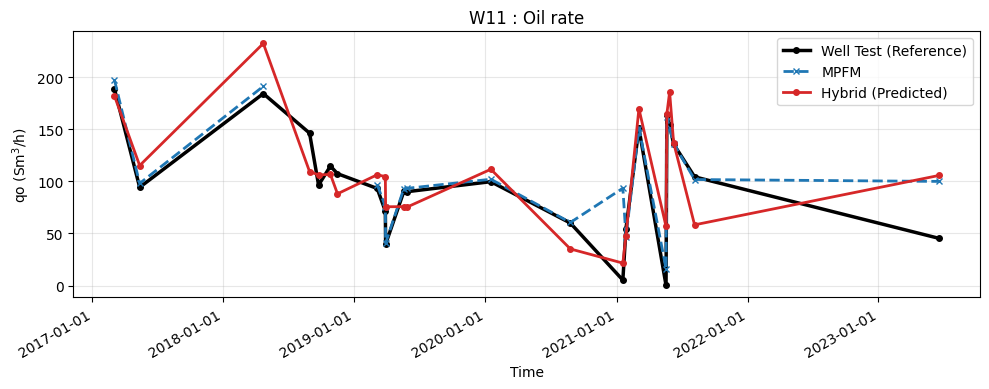

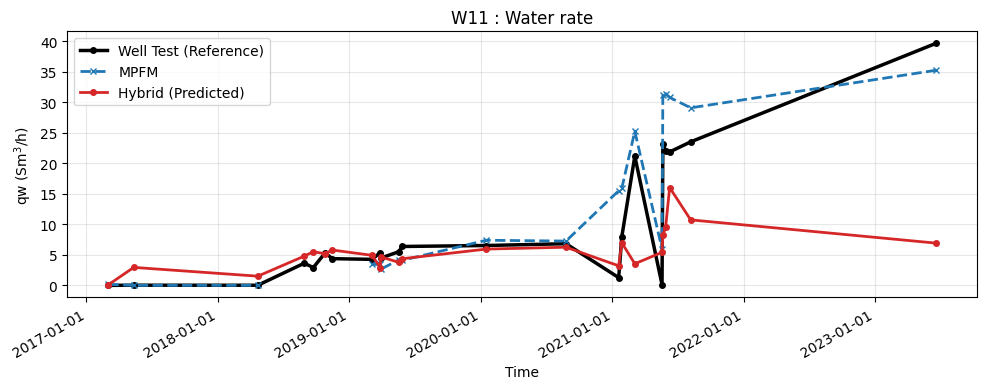

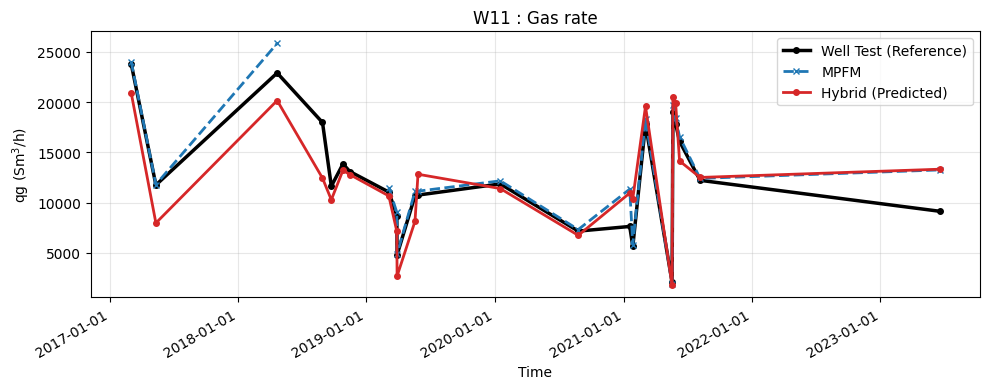

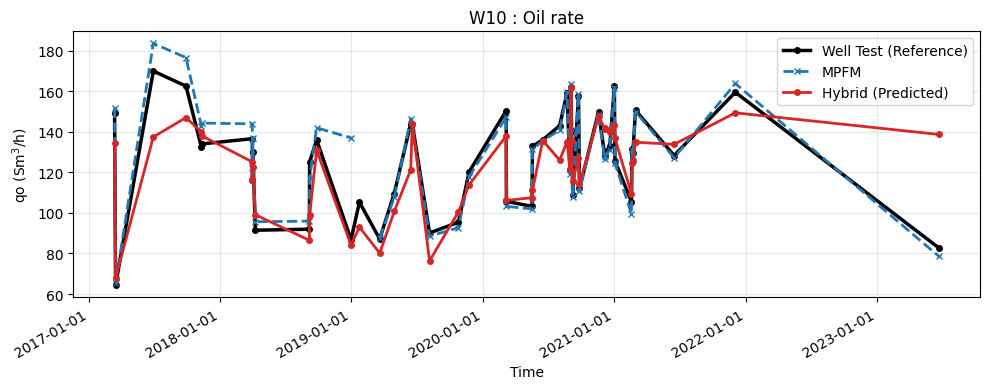

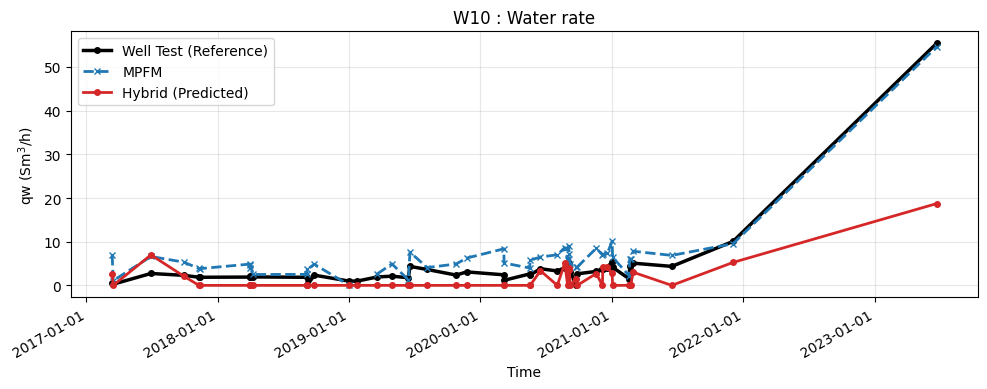

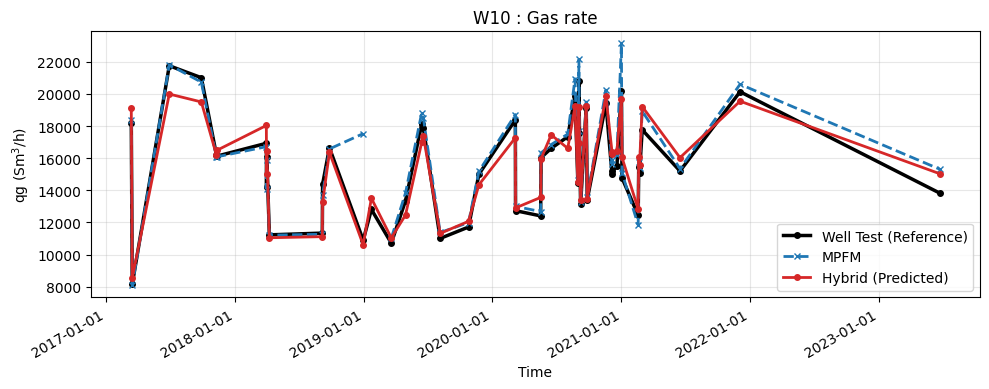

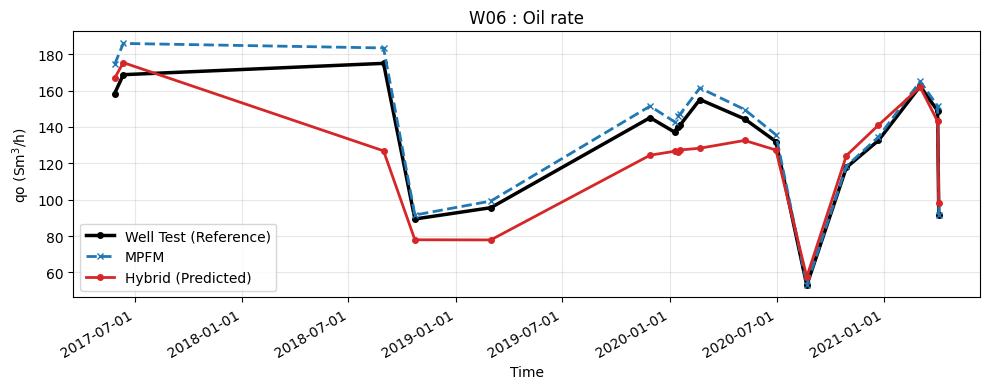

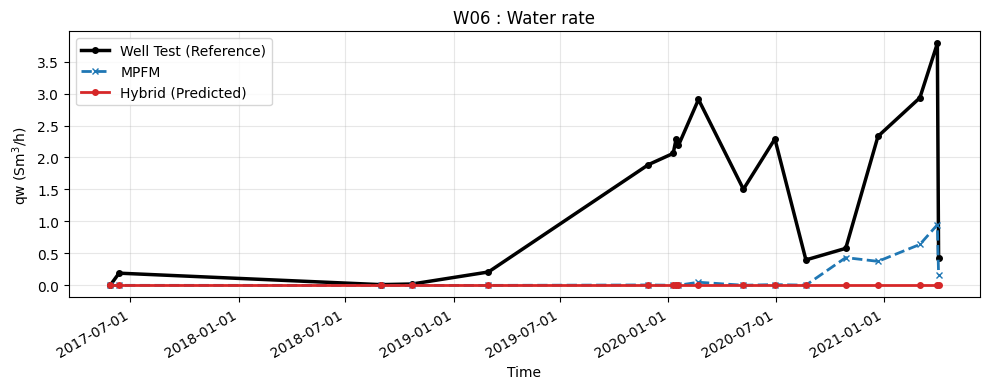

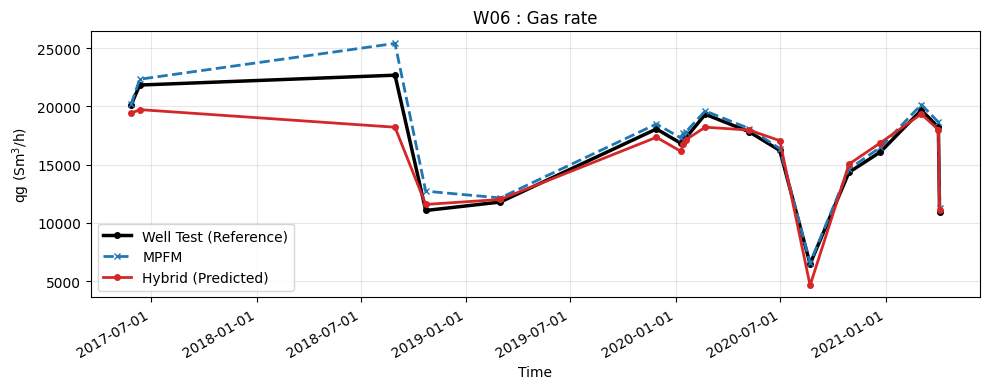

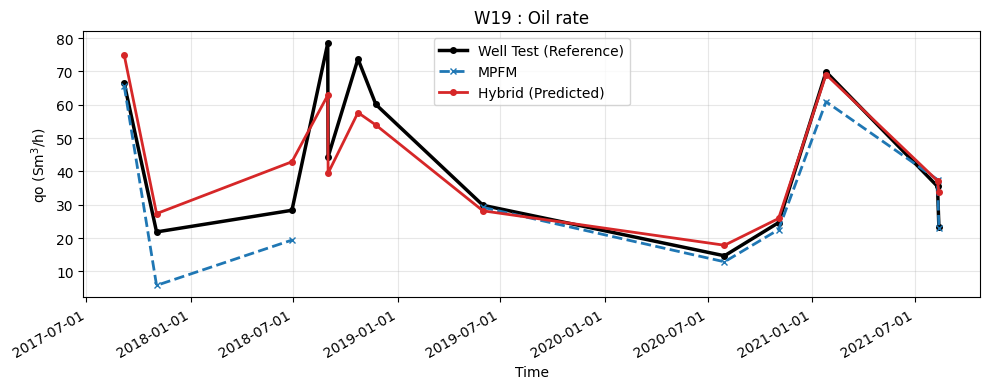

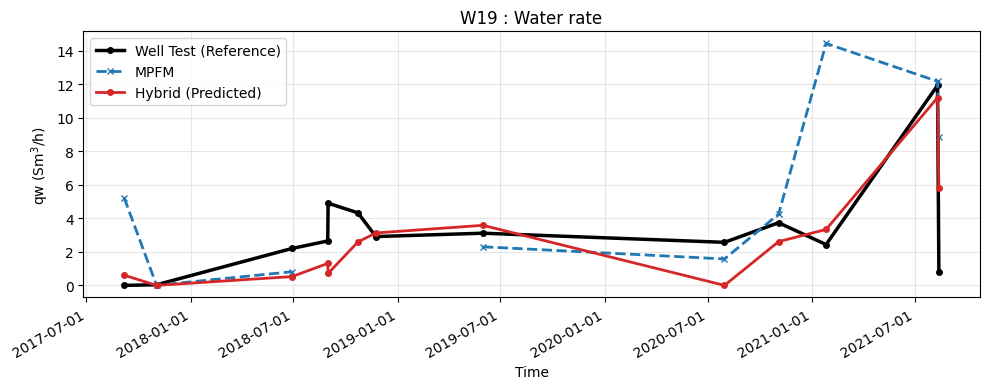

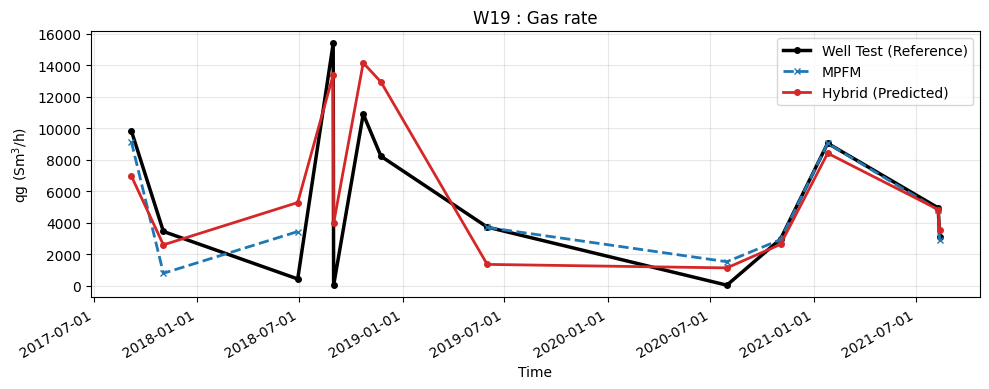

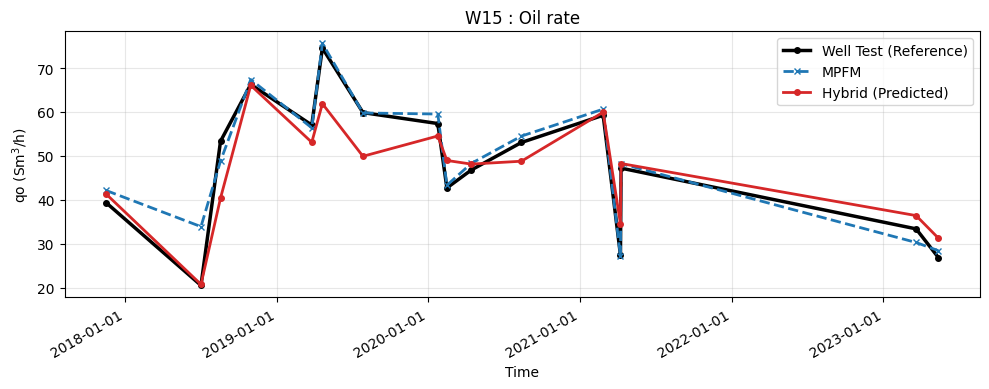

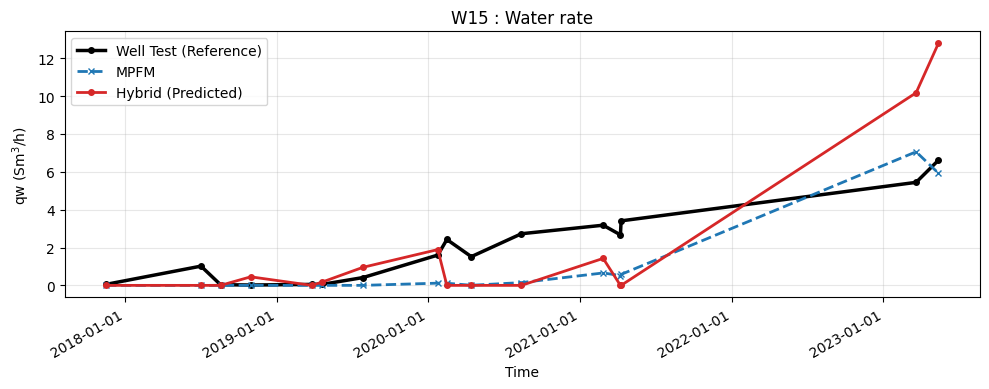

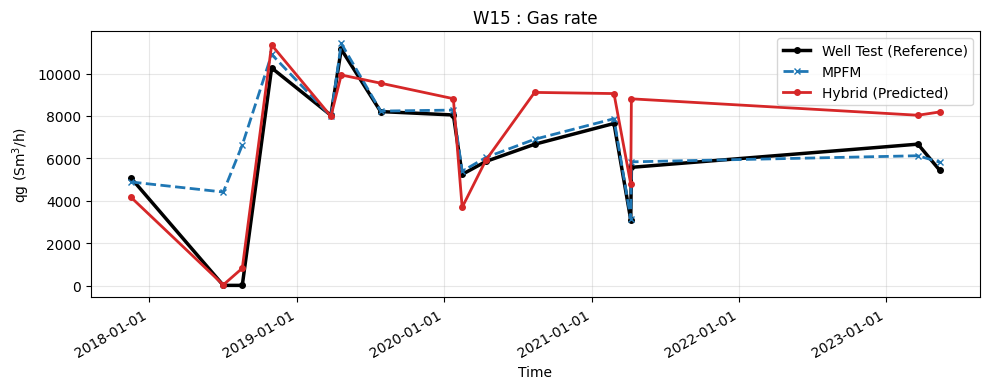

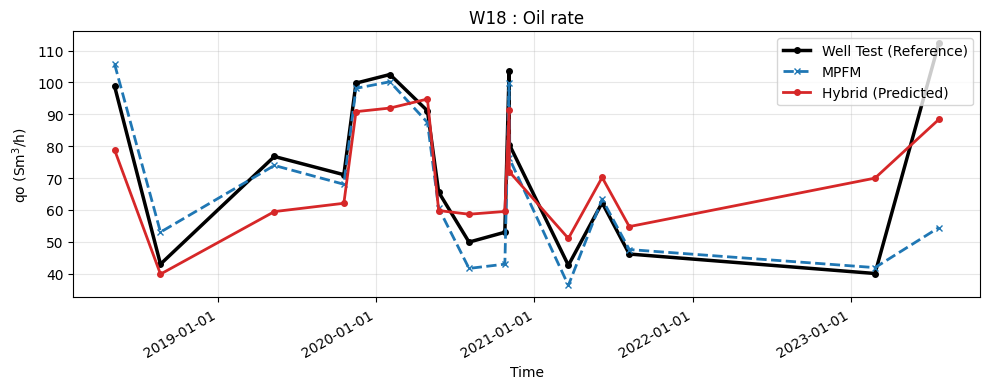

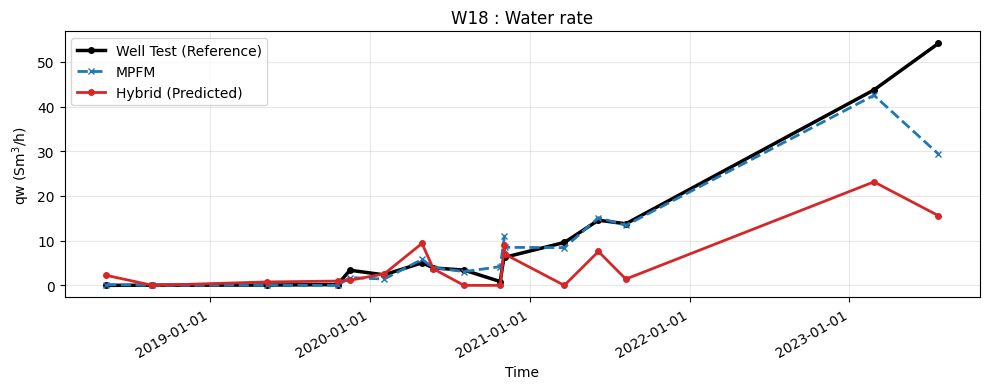

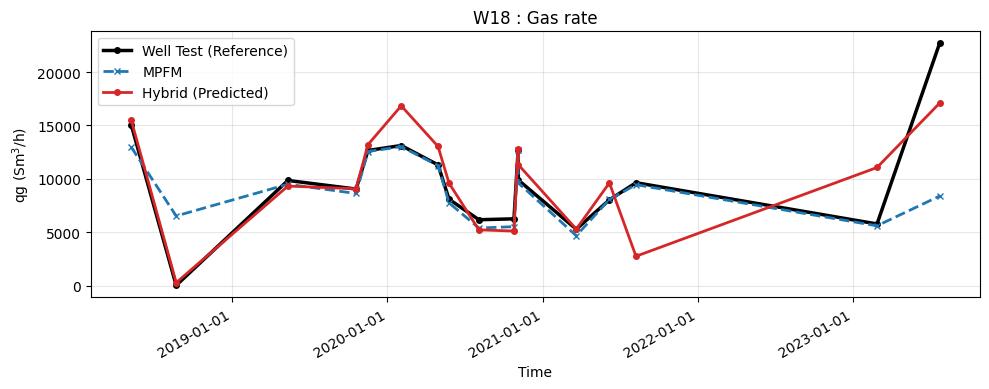

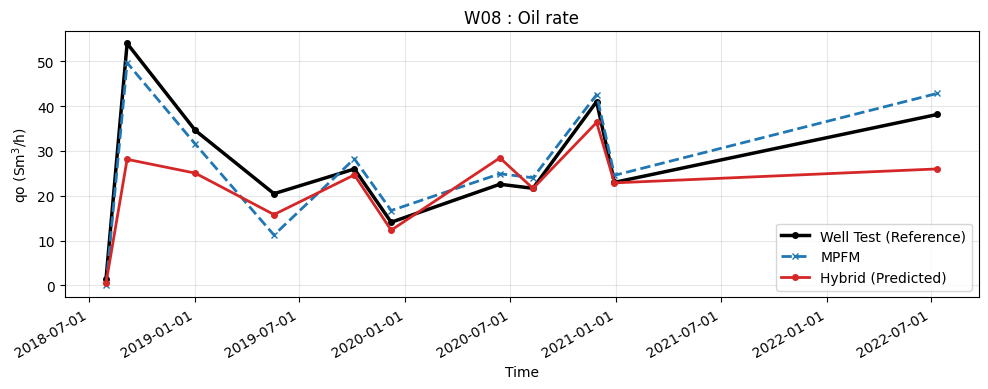

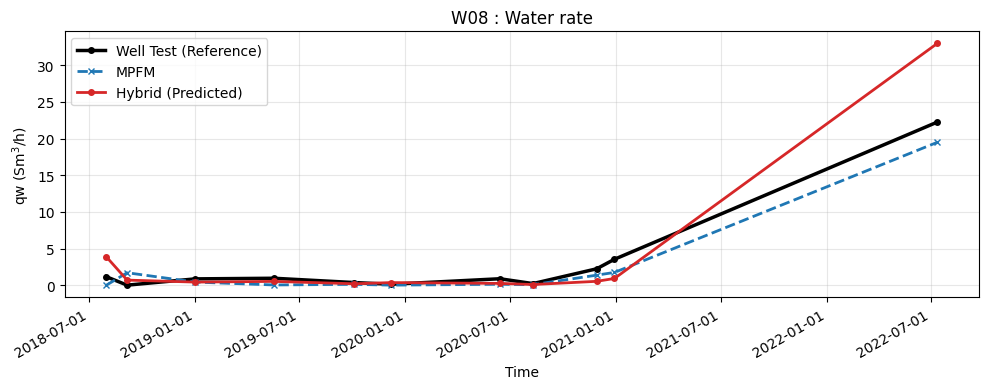

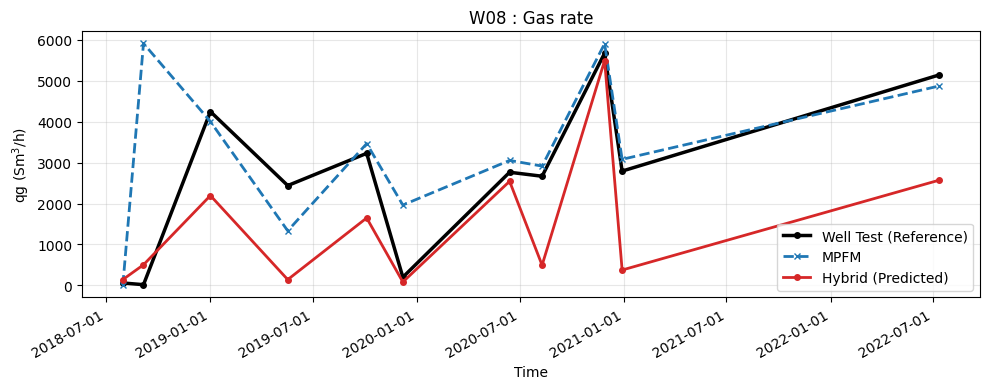

In [62]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [63]:
df_train_lowo, df_val_lowo, df_calibration_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
print(f"Train={len(df_train_lowo)}, Val={len(df_val_lowo)}, Calibration={len(df_calibration_lowo)}, Test={len(df_test_lowo)}")

Train=413, Val=121, Calibration=33, Test=188


In [64]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.7052


In [65]:
model_lowo.calibrate_physics_only(df=df_calibration_lowo)

In [66]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.5075906648856214,
   'mae': 15.770757141907412,
   'rmse': 22.40163209422354,
   'mape (%)': 17.032534299853026,
   'mpe (%)': 8.97121465372104},
  'qw': {'r2': 0.5181138010310875,
   'mae': 3.716263701732186,
   'rmse': 7.0345410841126785,
   'mape (%)': 261890079.6959963,
   'mpe (%)': 261889979.41213927},
  'qg': {'r2': 0.6007014965366654,
   'mae': 1881.6294324057044,
   'rmse': 2567.5858780754274,
   'mape (%)': 246.96386521782708,
   'mpe (%)': 227.51359265587075},
  'wgr': {'r2': 0.4126193092199766,
   'mae': 0.00032455337137528187,
   'rmse': 0.0006857191870219462,
   'mape (%)': 14200.097541367051,
   'mpe (%)': 14097.490270604214},
  'gor': {'r2': -1.56035153612528,
   'mae': 17.868423131612616,
   'rmse': 25.791386264550745,
   'mape (%)': 180.5831684875468,
   'mpe (%)': 155.14542627088883}}}

In [67]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.6634947660305663,
   'mae': 14.874427333817728,
   'rmse': 18.51878260241125,
   'mape (%)': 13.837528242107613,
   'mpe (%)': 4.999040119500584},
  'qw': {'r2': 0.6988400587981936,
   'mae': 3.0324258321723576,
   'rmse': 5.561118226077773,
   'mape (%)': 84958119.27879263,
   'mpe (%)': 84957972.76615965},
  'qg': {'r2': 0.20559614634062195,
   'mae': 3247.0429141681047,
   'rmse': 3621.56936880594,
   'mape (%)': 86.3314916097256,
   'mpe (%)': 46.41536876295994},
  'wgr': {'r2': 0.49292860856730725,
   'mae': 0.0002672684960418776,
   'rmse': 0.0006371196842020729,
   'mape (%)': 93.49565233158894,
   'mpe (%)': -58.279121591800696},
  'gor': {'r2': -5.96555604701364,
   'mae': 34.95931508842614,
   'rmse': 42.54051882167888,
   'mape (%)': 93.17463967952928,
   'mpe (%)': 49.18038168997872}}}

In [68]:
model_lowo.score_mpfm(df=df_test_lowo)

{'W10': {'qo': {'r2': 0.9558755822007586,
   'mae': 4.097103931082704,
   'rmse': 6.747460631336657,
   'mape (%)': 3.4385471015329907,
   'mpe (%)': 1.1195036225404436},
  'qw': {'r2': 0.914845350560488,
   'mae': 2.534164757658901,
   'rmse': 2.9862343181640876,
   'mape (%)': 514803794.36256707,
   'mpe (%)': 514803782.2220766},
  'qg': {'r2': 0.9347516171313208,
   'mae': 526.5498639725927,
   'rmse': 1044.5472477583376,
   'mape (%)': 468.00988521590955,
   'mpe (%)': 467.10686189036954},
  'wgr': {'r2': 0.9430119716173818,
   'mae': 0.0001717522364049444,
   'rmse': 0.00021586666326782136,
   'mape (%)': 93294.5562425683,
   'mpe (%)': 93282.73825845876},
  'gor': {'r2': 0.12062812181616034,
   'mae': 8.049534672255618,
   'rmse': 15.27820681136285,
   'mape (%)': 475.8282157361868,
   'mpe (%)': 471.8814956266265}}}

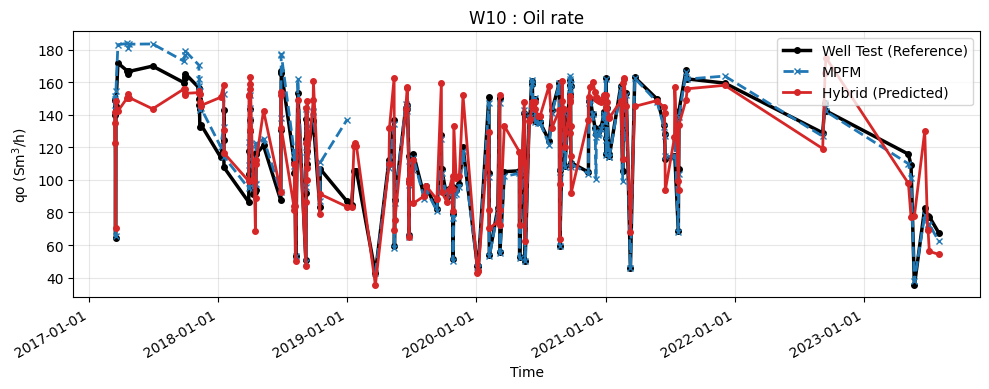

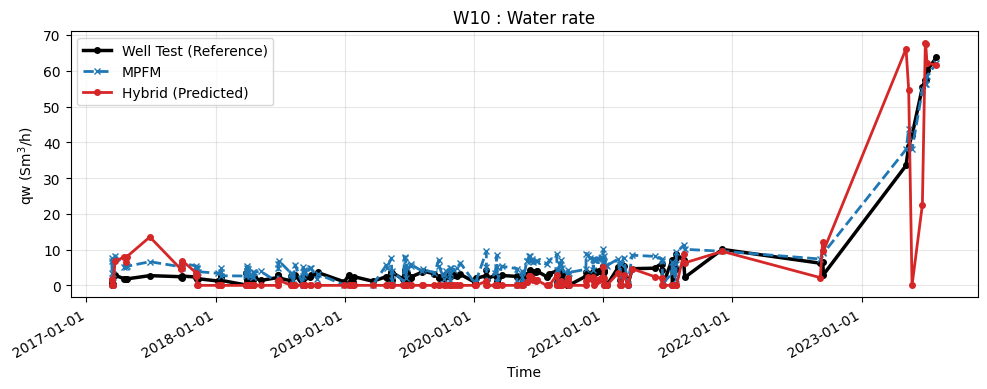

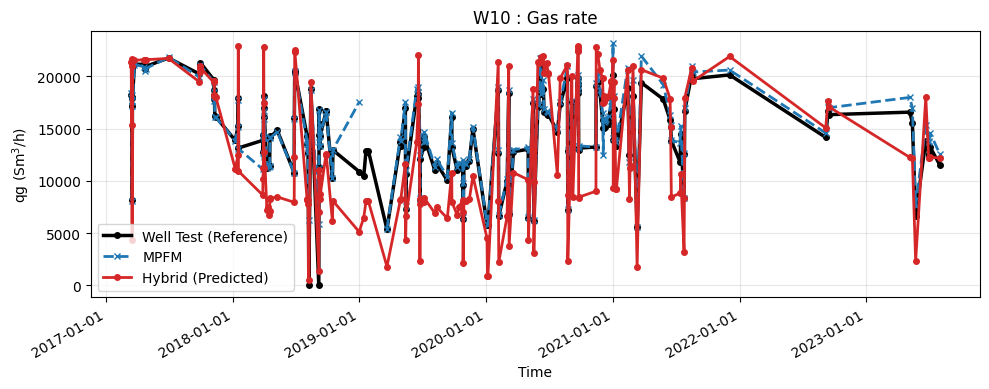

In [69]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [70]:
# resampler = Resampler()
# df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
# print(summarize_null(df=df_resampled))
# print(df_resampled.shape)

In [71]:
# df_resampled.index

In [72]:
# df_resampled.columns

In [73]:
# df_resampled[df_resampled["is_observed"] == 1].shape

In [74]:
# Monotonic
# df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

In [75]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [76]:
# summarize_null(df_generated)